In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.initializers import LecunNormal
from keras.models import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import GRU
import tensorflow as tf

2025-05-28 09:23:42.622324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 09:23:42.637048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 09:23:42.653236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 09:23:42.657608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 09:23:42.670589: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data = pd.read_csv('sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


We can observe that the column of interest is the third.

In [3]:
ts = data[data.columns[2]]

In [4]:
print(f"Missing values: {ts.isnull().values.any()}")
ts.describe()

Missing values: False


count    3252.000000
mean       82.070695
std        67.864736
min         0.000000
25%        24.200000
50%        67.750000
75%       122.700000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

The maximum and minimum values are relatively far from the mean and the 25% and 75% quartiles thus we can suspect that the dataset is probably noisy and definitely has outliers.

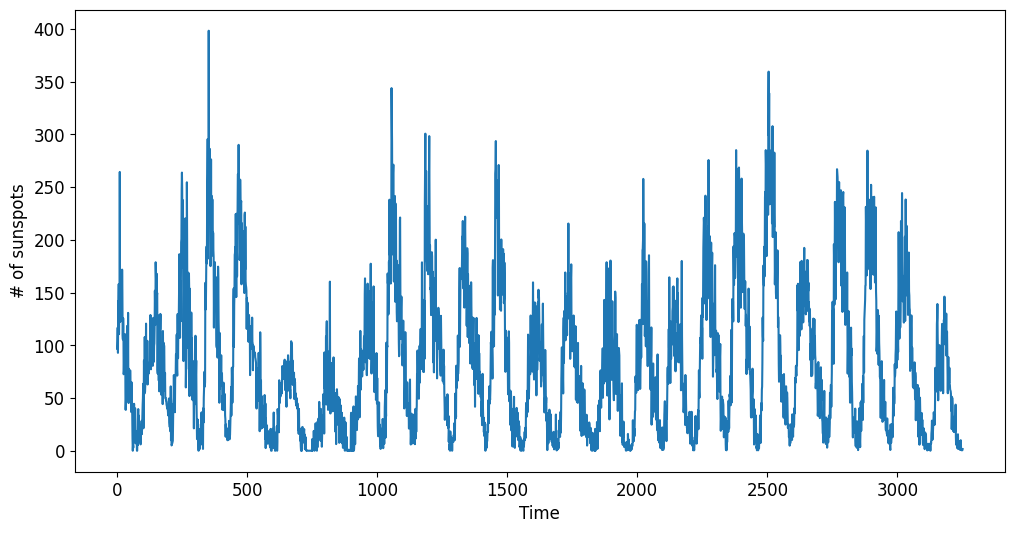

In [5]:
ts = ts.to_numpy()
fig = plt.figure(figsize=(12,6))
plt.plot(ts)
plt.ylabel("# of sunspots")
plt.xlabel("Time")
plt.show()

In [6]:
# Select a window size
window = 40

# Ratio for splitting
ratio = 0.9

# Number of neurons
first_layer = 50
second_layer = 25

# Activation function
ac_func = 'selu'

# Epochs
epochs = 30

# Early stopping iterations
early_stopping_patience = 2

# Validation ratio
val_ratio = 0.1

# Batch size
batch_size = 32

# Initialization strategy
init_strat = LecunNormal()

# Scale the data
mx = np.max(ts)
ts = ts / mx

# Test samples
horizon = int((1-ratio) * data.shape[0])

# Create lagged features
def create_features(data, window, horizon):
    X, y = [], []
    for i in range(window, len(data) - horizon + 1):
        X.append(data[i - window: i])
        y.append(data[i: i + horizon])
    return np.array(X), np.array(y)

# Reform the dataset based on the lag
train = ts[:-horizon]
test = ts[-horizon:]
X_train, y_train = create_features(train, window = window, horizon = horizon)

# Form test set
X_test = np.array([train[-window:]])
y_test = np.array([test])

In [7]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define the model
model = Sequential()
model.add(InputLayer(shape = (window,)))
model.add(BatchNormalization())
model.add(Dense(units = first_layer, activation = ac_func, kernel_initializer = init_strat))
model.add(Dense(units = second_layer, activation = ac_func, kernel_initializer = 'he_normal'))
model.add(Dense(horizon))

model.summary()

model.compile(loss = 'mse',  optimizer = 'adamW', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = early_stopping_patience, restore_best_weights = True)

# Fit model
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=1, 
                    validation_split = val_ratio,
                    callbacks = [early_stopping],
                    shuffle = False)

2025-05-28 09:23:44.666061: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 325)            │         8,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,935 (46.62 KB)

 Trainable params: 11,855 (46.31 KB)

 Non-trainable params: 80 (320.00 B)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1692 - mae: 0.3166 - val_loss: 0.0600 - val_mae: 0.1853
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520 - mae: 0.1758 - val_loss: 0.0409 - val_mae: 0.1595
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - mae: 0.1549 - val_loss: 0.0386 - val_mae: 0.1532
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350 - mae: 0.1494 - val_loss: 0.0359 - val_mae: 0.1449
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - mae: 0.1467 - val_loss: 0.0333 - val_mae: 0.1379
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331 - mae: 0.1451 - val_loss: 0.0318 - val_mae: 0.1343
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327 - mae: 0.1440 - val_loss: 0.0314 - val_mae: 0.1335
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - mae: 0.1432 - val_loss: 0.0317 - val_mae: 0.1347
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 

Based on the choice of window parameter:

    1) The batch normalization required four parameters for each input feature namely: (a) output scale, (b) output offset, (c) final input mean, (d) final input standard deviation. Thus, the number of parameters for that layer are lag*4

    2) The first dense layer requires window * (first_layer Neurons) + (first_layer biases) parameters

    3) The second dense layer requires first_layer * (second_layer Neurons) + (second_layer biases) parameters

    4) The output dense layer requires second_layer * (1 Neuron) + (1 bias) parameters

Thus, total number is: window * (4 + first_layer) + first_layer * second_layer + second_layer + (first_layer + second_layer + 1)

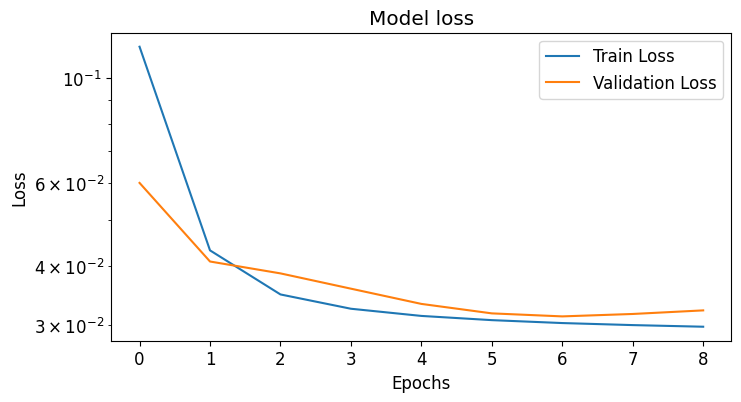

Train Root Mean Squared Error(RMSE): 0.16; Train Mean Absolute Error (MAE) : 0.12
Test Root Mean Squared Error(RMSE): 0.14; Test Mean Absolute Error (MAE) : 0.11


In [8]:
fig = plt.figure(figsize=(8,4))
plt.title('Model loss')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

train_score = model.evaluate(X_train, y_train, verbose=0)
print(f'Train Root Mean Squared Error(RMSE): {np.sqrt(train_score[0]):.2f}; Train Mean Absolute Error (MAE) : {train_score[1]:.2f}')
test_score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Root Mean Squared Error(RMSE): {np.sqrt(test_score[0]):.2f}; Test Mean Absolute Error (MAE) : {test_score[1]:.2f}')

We observe that the validation curve follows the training loss curve. That means that the model accuratelly captures the characteristics of the time series. Moreover, the RMSE and MAE for both training and validation are reasonably close.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


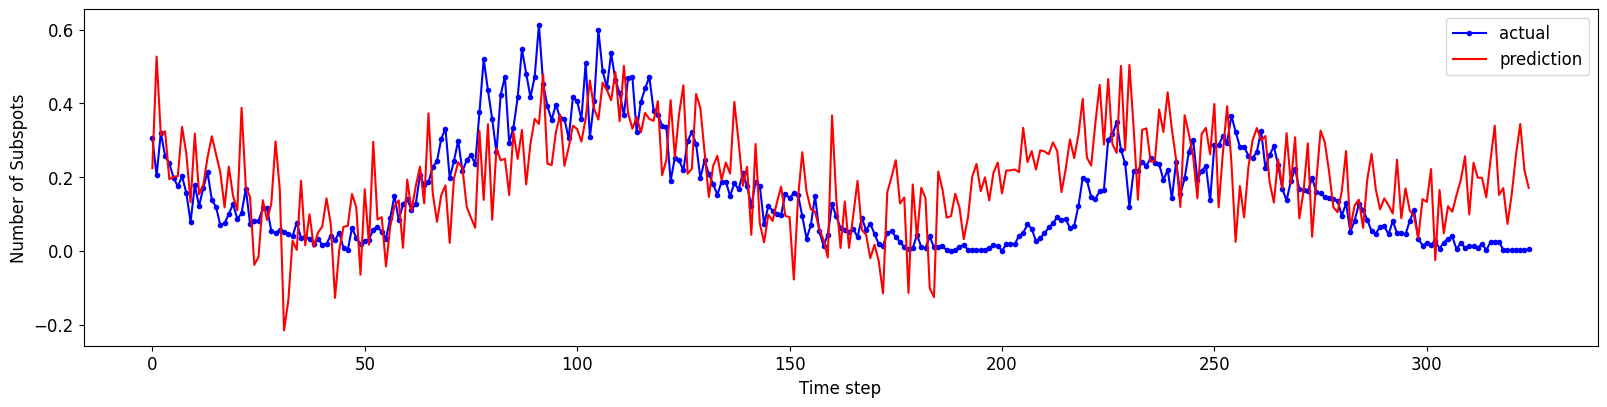

RMSE: 0.1350282582632689, MAE: 0.3313966376998746


In [9]:
# Plot function for predictions and actuals
def plot_predictions(y_test, predictions):
    
    fig = plt.figure(figsize=(16,4))
    plt.plot(range(len(y_test)), y_test, 'b.-', label = "actual")
    plt.plot(range(len(y_test)), predictions, 'r', label = "prediction")
    plt.tight_layout()

    plt.ylabel('Number of Subspots')
    plt.xlabel('Time step')

    plt.legend()
    plt.show()




# Multi-step ahead prediction
predict = model.predict(X_test)

plot_predictions(y_test[0], predict[0])

print(f"RMSE: {np.sqrt(mean_squared_error(predict[0], y_test[0]))}, MAE: {np.sqrt(mean_absolute_error(predict[0], y_test[0]))}")

The predictions and the actuals are in quantitative agreement with small deviations. As the prediction horizon gets further away the predictions seem to deviate from the actuals progressively more.

In [10]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define architecture based on the lag choice
model_gru = Sequential()
model_gru.add(InputLayer(shape = (window, 1)))
model_gru.add(GRU(units = first_layer, activation = ac_func, kernel_initializer = init_strat, return_sequences = True))
model_gru.add(GRU(units = second_layer, activation = ac_func, kernel_initializer = init_strat))
model_gru.add(Dense(horizon))

# Print model summary
model_gru.summary()

model_gru.compile(loss='mse',  optimizer='AdamW', metrics = ['mae'])

X_train_alt = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_alt = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.0005,
                               patience = early_stopping_patience,
                               restore_best_weights = True)

# Fit the model
history = model_gru.fit(X_train_alt, y_train, epochs = epochs, batch_size = batch_size, verbose = 1,
                        validation_split = val_ratio,
                        callbacks = [early_stopping],
                        shuffle = False)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 25)             │         5,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 325)            │         8,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,175 (86.62 KB)

 Trainable params: 22,175 (86.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0589 - mae: 0.1797 - val_loss: 0.0415 - val_mae: 0.1721
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0341 - mae: 0.1476 - val_loss: 0.0379 - val_mae: 0.1538
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0337 - mae: 0.1470 - val_loss: 0.0338 - val_mae: 0.1441
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0327 - mae: 0.1434 - val_loss: 0.0323 - val_mae: 0.1382
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0321 - mae: 0.1413 - val_loss: 0.0323 - val_mae: 0.1376
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0317 - mae: 0.1399 - val_loss: 0.0322 - val_mae: 0.1368


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


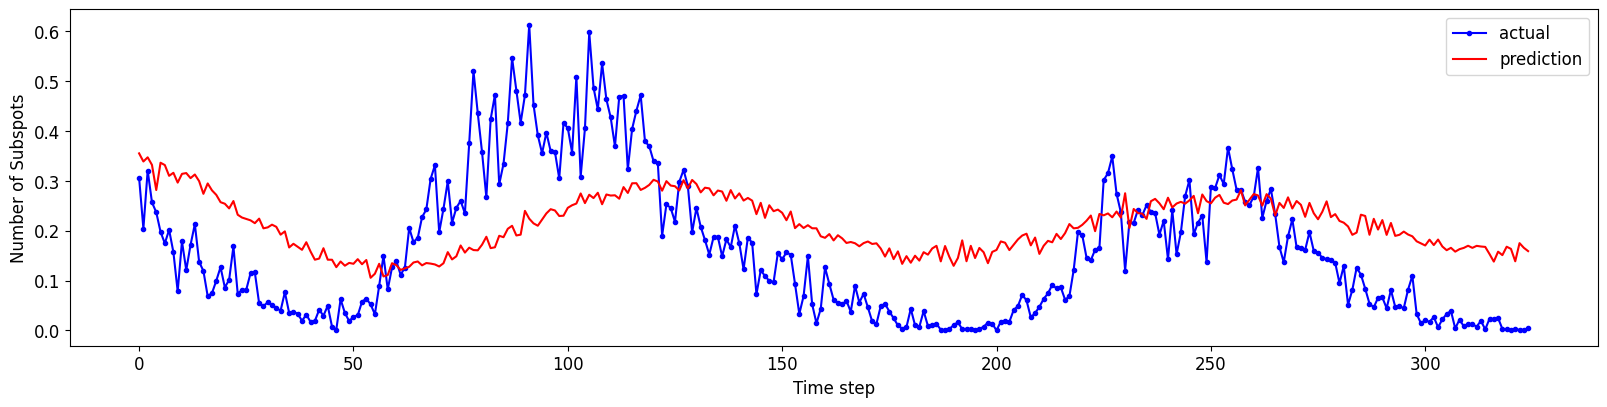

RMSE: 0.13197508830513577, MAE: 0.34115698200987155


In [11]:
# Compute predictions
train_predict_alt = model_gru.predict(X_train_alt)[0]
test_predict_alt = model_gru.predict(X_test_alt)[0]
y_test_alt = y_test[0]

# Run the plot function
plot_predictions(y_test_alt, test_predict_alt)

# Print MAE and RMSE
print(f"RMSE: {np.sqrt(mean_squared_error(test_predict_alt, y_test_alt))}, MAE: {np.sqrt(mean_absolute_error(test_predict_alt, y_test_alt))}")

The GRU presents worse results in terms of MAE and RMSE compared to MLP, however this is caused by the strict stopping criterion imposed during training. With more training steps the GRU will present better results and that can be deduced by the fact that the validation loss for almost the same amount of steps is better compared to the MLP. In both cases the beginning of forecasts is close to the actuals but then it drifts away for longer horizons. This is caused by the change in frequency in the dataset.